# Clustering
When the features have been extracted, there's now a list of files containing one entry per epoch. Clustering can be applied in 3 main ways to check any patterns in the data:
1. Patients
2. Pre/Post procedure
3. cTBS/iTBS/sham

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import os
import numpy as np
from scipy import stats

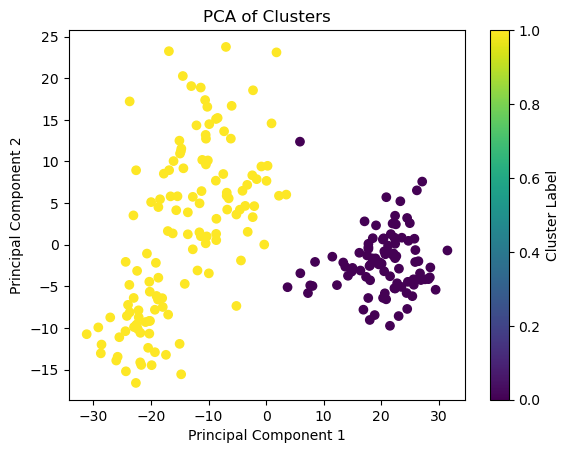

[0.45671544 0.09234909]
[341.34786631  69.02145348]


In [14]:
csv_files = [
    "features_test_1.csv",
    "features_test_2.csv"
]
df = pd.concat((pd.read_csv(f, header=[0, 1]) for f in csv_files))

# outlier removal
# iqr
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1
# df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
# z-score
z_scores = np.abs(stats.zscore(df))
df = df[(z_scores < 3).all(axis=1)]

# normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

# clustering
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(df)

# Plot result with pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df)

plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=clusters, cmap='viridis')
plt.title("PCA of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

Original DataFrame shape: (613, 6975)
Filtered DataFrame shape: (595, 6975)


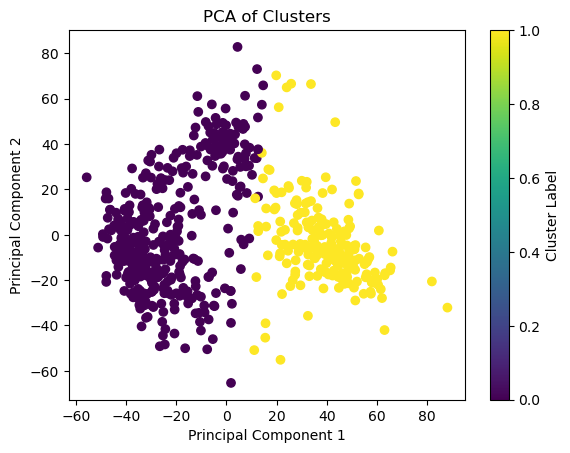

Principal Component 1:
('app_entropy', 'Fp2'): -0.027513331657948163
('hjorth_complexity', 'Fp2'): 0.027419532907133084
('hjorth_complexity', 'Fpz'): 0.027213220534684536
('app_entropy', 'Fpz'): -0.02717200072010072
('app_entropy', 'AF4'): -0.027142298965370737
('hjorth_complexity', 'Fp1'): 0.027106192043694584
('app_entropy', 'Fp1'): -0.026926522789678095
('hjorth_complexity', 'AF4'): 0.026817148827603568
('app_entropy', 'AF3'): -0.026806944180355143
('hjorth_complexity', 'AF3'): 0.026681691394372455
('std', 'Fp2'): 0.026501518558654152
('variance', 'Fp2'): 0.026387185838651035
('variance', 'Fp1'): 0.026112358704575574
('variance', 'Fpz'): 0.026086840388341786
('app_entropy', 'F6'): -0.0260559608117288
('std', 'Fp1'): 0.02602988245231022
('ptp_amp', 'Fp2'): 0.026016228038213275
('time_corr', 'TP8-F8'): -0.0259784359408325
('std', 'Fpz'): 0.02587032307933937
('hjorth_complexity', 'F6'): 0.025803050262242222


Principal Component 2:
('std', 'F1'): -0.03550319237336682
('std', 'Fz'): -0.

In [38]:
feature_files = os.listdir("features")
labels_df = pd.read_csv('labels.csv', delimiter=';')

# Comparing pre vs post for all patients
# sham_filenames = labels_df[labels_df['procedure'] == 'sham']['filename']
# feature_files = sham_filenames
# iTBS_filenames = labels_df[labels_df['procedure'] == 'itbs']['filename']
# feature_files = sham_filenames
# ctbs_filenames = labels_df[labels_df['procedure'] == 'ctbs']['filename']
# feature_files = sham_filenames

# read csv with 2 header rows
dfs = [pd.read_csv(os.path.join("features", file), header=[0, 1]) for file in feature_files]
df = pd.concat(dfs)
feature_names = df.columns

# outlier removal
OUTLIER_THRESHOLD = 0.10
Q1 = df.quantile(0.10)
Q3 = df.quantile(0.90)
IQR = Q3 - Q1
def is_outlier(row):
    return ((row < (Q1 - 1.5 * IQR)) | (row > (Q3 + 1.5 * IQR))).sum()
outlier_counts = df.apply(is_outlier, axis=1)
threshold = len(df.columns) * OUTLIER_THRESHOLD
rows_to_drop = outlier_counts[outlier_counts > threshold].index
df_filtered = df.drop(index=rows_to_drop)
print(f"Original DataFrame shape: {df.shape}")
print(f"Filtered DataFrame shape: {df_filtered.shape}")
df = df_filtered

# normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

# # Apply KMeans clustering
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(df)

# # Evaluate the clustering results
# score = metrics.adjusted_rand_score(your_labels, clusters)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df)

plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=clusters, cmap='viridis')
plt.title("PCA of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Attributions
loadings = pca.components_
for i, component in enumerate(loadings):
    component_loadings = zip(feature_names, component)
    sorted_loadings = sorted(component_loadings, key=lambda x: abs(x[1]), reverse=True)
    print(f"Principal Component {i+1}:")
    for feature, loading in sorted_loadings[:20]:
        print(f"{feature}: {loading}")
    print("\n")